# How good is the SOFA score for predicting patient mortality with our dataset?

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import random
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import stats

In [2]:
# Custom import
import sys
sys.path.append('../src/')
from Thomas_code import patients, feature_conversion
import flm_tools, plots

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

In [4]:
# set plotting params
mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.reload_library()
rcparams = plots.stdrcparams1()
mpl.rcParams.update(rcparams)

During a monthly meeting of the SCRIPT center (the holder of the NIH grant supporting this research), some cool graphs showing how SOFA scores vary as days go by captured the attention of many people (including me). SOFA stands for the Sequential Organ Failure Assessment: It quantifies the degree of failure for 6 organ systems: Respiratory (through PF ratio), Coagulation (through platelet counts), Liver (Bilirubin), Cardiovascular (mean arterial pressure), Neurological (Glasgow Coma Score) and Kidneys (Creatinine and urine output). It then maps values of each lab to a scale from 0 to 4, where 0 means no organ failure, and 4 is the worst degree of organ failure. These subscores are then added for the total SOFA score. One nice thing of this score is that it uses labs that can be taken daily (although no more frequent than daily), so it can summarize the status of organ failure for the previous day. It has also shown good value in predicting patient mortality (https://pubmed.ncbi.nlm.nih.gov/11594901/).  
However, there are some intricacies in SOFA score that made us wonder if it is enough to just use the total SOFA score, or if we could find that only one of the organ systems is informative enough.  
So I simply pursued a logistic regression approach to tease apart this score.

## Let's do logistic regression on each component of the SOFA score. Rationale: Certain individual SOFA subscores might be more informative on discharge than the overall SOFA score.  
I'm thinking about two possibilities:  
-Use Day 1 SOFA score: Some literature suggests that day 1 score is good enough for prognosis.  
-Use median SOFA score: To capture a "representative value".

### Loading table with measurements, patient outcomes, and other info

In [5]:
clean_all_table = flm_tools.get_cleaned_data(version='2021-08-31/210831_digest',
                                             multiple_visits='all')

# Checking number of patient encounters
len(clean_all_table['case_number'].drop_duplicates())

514

In [6]:
# Loading relevant part of SOFA score table
sofa = patients.modified_edw_rc('sofa_scores',
                                revision='2021-08-31/210831_digest',
                                columns=['case_number',
                                         'icu_rank',
                                         'ICU_Day',
                                         'P_F_ratio_points',
                                         'platelet_points',
                                         'bilirubin_points',
                                         'htn_points',
                                         'gcs_points',
                                         'renal_points',
                                         'SOFA']).drop_duplicates()

In [7]:
sofa_with_binary_outcomes = pd.merge(clean_all_table[['case_number',
                                                      'discharge_disposition_binary']].drop_duplicates(),
                                     sofa)

Sanity check: Expired cases should have higher SOFA scores. Given previous issues with this table, that might need to be checked, even when it is common sense.

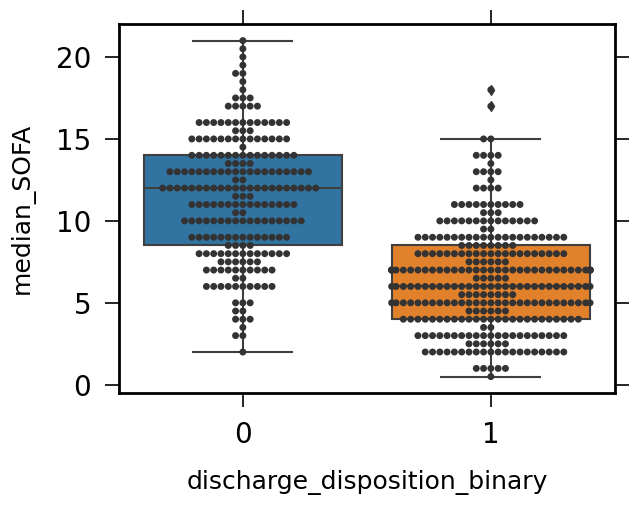

In [8]:
median_sofa_per_encounter = sofa_with_binary_outcomes.groupby(['case_number',
                                                               'discharge_disposition_binary'])['SOFA'].median().to_frame('median_SOFA').reset_index()

ax = sns.boxplot(x="discharge_disposition_binary",
                 y="median_SOFA", data=median_sofa_per_encounter)
ax = sns.swarmplot(x="discharge_disposition_binary",
                   y="median_SOFA", data=median_sofa_per_encounter, color=".2")
plt.show()

### Dealing with missing data in SOFA scores table

My question: Anna (from EDW team) built the SOFA score table for the unified database, and I had noticed that the column corresponding to the total SOFA score for any given day was indeed the sum of all subscores. **However, if a subscore was NULL, she assumed it was zero.** The problem is that zero in SOFA means the patient did not have failure in that particular organ system, so I asked if I could assume zero whenever data was missing.  
From Catherine Gao (a fellow lab mate who is also an intensive care physician): To a certain extent, yes; if a patient is doing very well, they might not have some things (like **bilirubin or PaO2**) checked and other things like GCS might not be documented (though if patients are in the ICU, the nurses are very good at documenting most things).
Most patients should have at least **platelets, MAP, and creatinine** though, so if those are NULL that would be weird.

In [9]:
sofa_with_binary_outcomes.isna().sum()

case_number                        0
discharge_disposition_binary       0
icu_rank                           0
ICU_Day                            0
P_F_ratio_points                3063
platelet_points                   97
bilirubin_points                1952
htn_points                         2
gcs_points                         0
renal_points                     120
SOFA                               0
dtype: int64

Indeed, the above missing entry count aligns with Cathy's expectations.

In [10]:
sofa_with_binary_outcomes = sofa_with_binary_outcomes.dropna(subset=['platelet_points',
                                                                     'htn_points',
                                                                     'renal_points'])

In [11]:
sofa_with_binary_outcomes.isna().sum()

case_number                        0
discharge_disposition_binary       0
icu_rank                           0
ICU_Day                            0
P_F_ratio_points                2936
platelet_points                    0
bilirubin_points                1844
htn_points                         0
gcs_points                         0
renal_points                       0
SOFA                               0
dtype: int64

The remaining NULLs will be assumed to be zero, per above.

In [12]:
sofa_with_binary_outcomes = sofa_with_binary_outcomes.fillna(0)

In [13]:
# Now checking absence of NULLs
sofa_with_binary_outcomes.isna().sum()

case_number                     0
discharge_disposition_binary    0
icu_rank                        0
ICU_Day                         0
P_F_ratio_points                0
platelet_points                 0
bilirubin_points                0
htn_points                      0
gcs_points                      0
renal_points                    0
SOFA                            0
dtype: int64

Sanity checking again after dealing with missing data

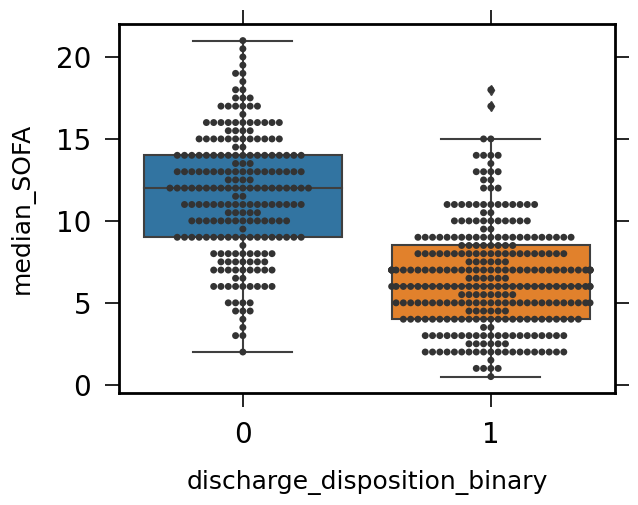

In [14]:
median_sofa_per_encounter = sofa_with_binary_outcomes.groupby(['case_number',
                                                               'discharge_disposition_binary'])['SOFA'].median().to_frame('median_SOFA').reset_index()

ax = sns.boxplot(x="discharge_disposition_binary",
                 y="median_SOFA", data=median_sofa_per_encounter)
ax = sns.swarmplot(x="discharge_disposition_binary",
                   y="median_SOFA", data=median_sofa_per_encounter, color=".2")
plt.show()

Nothing pops up from above (at least to me).

Normalize "features" to be able to compare coefficients.

In [15]:
# Don't want to deal with the numpy -> pandas conversion
# AKA, no sklearn
features = sofa_with_binary_outcomes.drop(labels=['case_number',
                                                  'icu_rank',
                                                  'ICU_Day',
                                                  'discharge_disposition_binary'], axis=1)

sofa_with_binary_outcomes[['P_F_ratio_points',
                           'platelet_points',
                           'bilirubin_points',
                           'htn_points',
                           'gcs_points',
                           'renal_points',
                           'SOFA']] = (features - features.min())/(features.max() -features.min())

### Logistic regression on Day 1 SOFA subscores  
Some patients will have multiple Day 1 entries since they went in and out of the ICU during a particular hospitalization. Will use day 1 of first ICU visit.

In [16]:
f = (sofa_with_binary_outcomes['icu_rank'] == 1) & (sofa_with_binary_outcomes['ICU_Day'] == 1)
day1_sofa = sofa_with_binary_outcomes.loc[f]
print(f"There are {day1_sofa['case_number'].nunique()} unique patient encounters with a valid Day 1 SOFA score")

There are 480 unique patient encounters with a valid Day 1 SOFA score


In [17]:
from statsmodels.formula.api import logit

In [18]:
model_collect = {}

#### Overall initial SOFA

Optimization terminated successfully.
         Current function value: 0.667770
         Iterations 5


Likelihood Ratio :  14.696581119524808
LR p-value :  0.00012627525611022484


Dep. Variable:,discharge_disposition_binary,No. Observations:,480
Model:,Logit,Df Residuals:,478
Method:,MLE,Df Model:,1
Date:,"Fri, 04 Mar 2022",Pseudo R-squ.:,0.02241
Time:,11:46:13,Log-Likelihood:,-320.53
converged:,True,LL-Null:,-327.88
Covariance Type:,nonrobust,LLR p-value:,0.0001263


Prediction table
 [[ 54. 152.]
 [ 34. 240.]]
Specificity:  0.2621359223300971
Sensitivity:  0.8759124087591241


,coeff,pvals,conf_lower,conf_higher,prob,input
Intercept,1.056706,0.000003,0.470330,1.643082,0.742061,Intercept
SOFA,-1.852586,0.000170,-3.121982,-0.583190,0.135570,SOFA


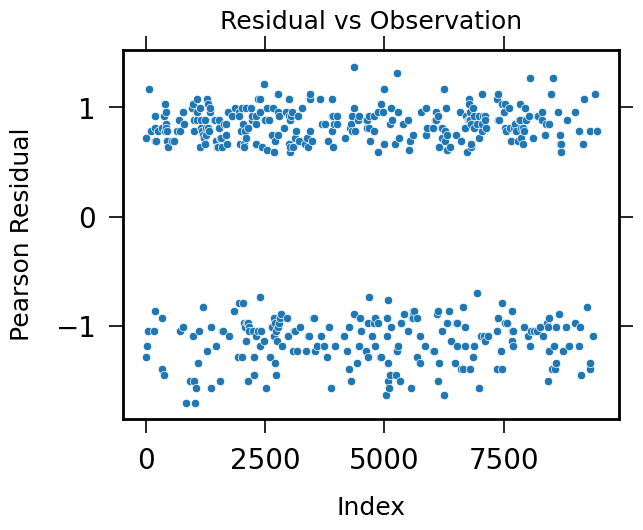

In [19]:
# This formulation (y ~ X) includes the intercept by default.
# Manually adding an intercept in statsmodels becomes necessary when using sm.Logit(y, X).
overall_initial_SOFA = logit("discharge_disposition_binary ~ SOFA",
                             data = day1_sofa).fit()

result_table = flm_tools.logistic_reg_outputter(overall_initial_SOFA,
                                                title='Regression: survival ~ initial SOFA')

model_collect['overall_initial_SOFA'] = overall_initial_SOFA

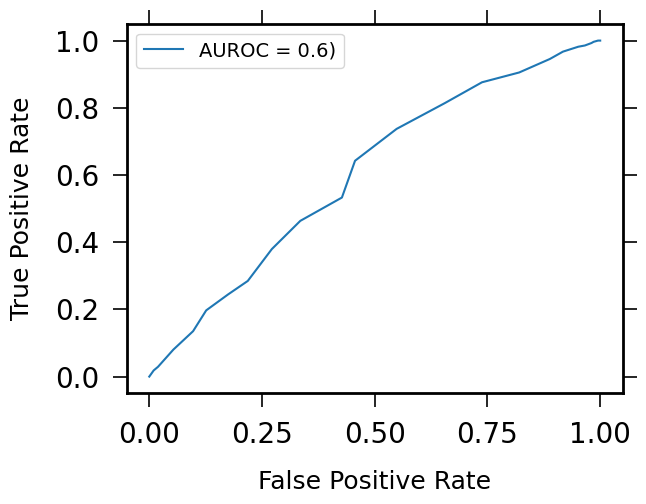

In [20]:
# Curious to observe the ROC for each model
y_true = day1_sofa['discharge_disposition_binary']
y_pred = overall_initial_SOFA.predict(day1_sofa['SOFA'])

from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(y_true, y_pred)
auc1 = auc(fpr, tpr)
plt.plot(fpr, tpr, label="AUROC = "+str(round(auc1, 2))+")")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

#### Initial platelet subscore

Optimization terminated successfully.
         Current function value: 0.655618
         Iterations 5


Likelihood Ratio :  26.36236377284763
LR p-value :  2.8300151897918653e-07


Dep. Variable:,discharge_disposition_binary,No. Observations:,480
Model:,Logit,Df Residuals:,478
Method:,MLE,Df Model:,1
Date:,"Fri, 04 Mar 2022",Pseudo R-squ.:,0.04020
Time:,11:46:15,Log-Likelihood:,-314.70
converged:,True,LL-Null:,-327.88
Covariance Type:,nonrobust,LLR p-value:,2.830e-07


Prediction table
 [[ 63. 143.]
 [ 40. 234.]]
Specificity:  0.3058252427184466
Sensitivity:  0.8540145985401459


,coeff,pvals,conf_lower,conf_higher,prob,input
Intercept,0.599294,1.190243e-07,0.307758,0.890830,0.645495,Intercept
platelet_points,-1.699047,7.732971e-07,-2.584612,-0.813481,0.154590,platelet_points


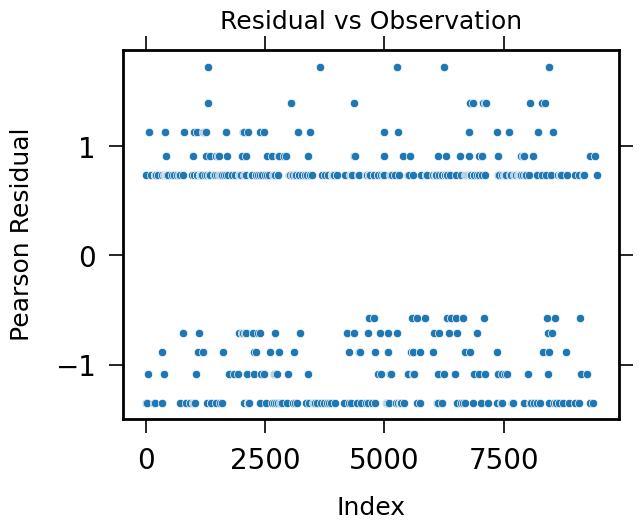

In [21]:
initial_platelets = logit("discharge_disposition_binary ~ platelet_points",
                          data = day1_sofa).fit()

result_table = flm_tools.logistic_reg_outputter(initial_platelets,
                                                title='Regression: survival ~ initial platelet points')

model_collect['initial_platelets'] = initial_platelets

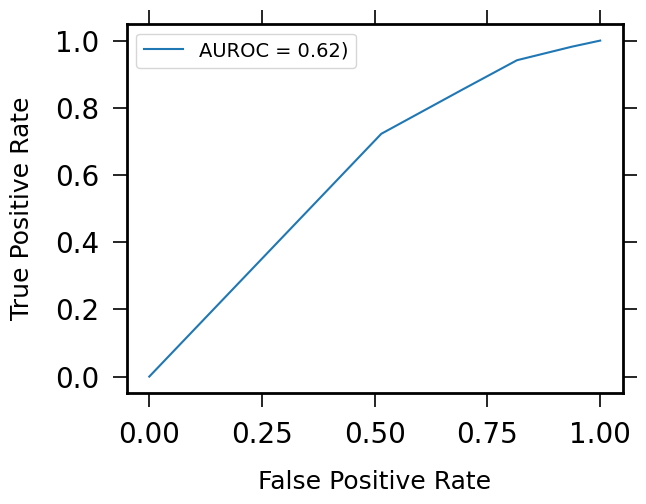

In [22]:
y_pred = initial_platelets.predict(day1_sofa['platelet_points'])

fpr, tpr, _ = roc_curve(y_true, y_pred)
auc1 = auc(fpr, tpr)
plt.plot(fpr, tpr, label="AUROC = "+str(round(auc1, 2))+")")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

#### Including all initial subscores

Optimization terminated successfully.
         Current function value: 0.644122
         Iterations 5


Likelihood Ratio :  37.397912339857044
LR p-value :  1.472721697493057e-06


Dep. Variable:,discharge_disposition_binary,No. Observations:,480
Model:,Logit,Df Residuals:,473
Method:,MLE,Df Model:,6
Date:,"Fri, 04 Mar 2022",Pseudo R-squ.:,0.05703
Time:,11:46:16,Log-Likelihood:,-309.18
converged:,True,LL-Null:,-327.88
Covariance Type:,nonrobust,LLR p-value:,1.473e-06


Prediction table
 [[ 74. 132.]
 [ 47. 227.]]
Specificity:  0.3592233009708738
Sensitivity:  0.8284671532846716


,coeff,pvals,conf_lower,conf_higher,prob,input
Intercept,0.911603,0.000168,0.287481,1.535725,0.713328,Intercept
gcs_points,0.363963,0.243447,-0.439788,1.167714,0.589999,gcs_points
renal_points,-0.286506,0.240035,-0.914638,0.341625,0.428859,renal_points
P_F_ratio_points,-0.309529,0.315342,-1.103587,0.484529,0.423230,P_F_ratio_points
htn_points,-0.428792,0.129186,-1.156717,0.299133,0.394415,htn_points
bilirubin_points,-0.773596,0.089860,-1.948414,0.401221,0.315702,bilirubin_points
platelet_points,-1.458852,0.000103,-2.426391,-0.491312,0.188643,platelet_points


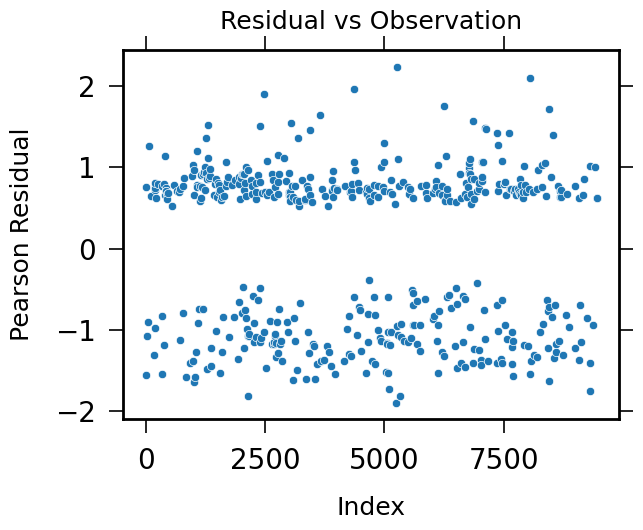

In [23]:
subscore_initial_SOFA = logit("discharge_disposition_binary ~ P_F_ratio_points + platelet_points + bilirubin_points + htn_points + gcs_points + renal_points",
                              data = day1_sofa).fit()

result_table = flm_tools.logistic_reg_outputter(subscore_initial_SOFA,
                                                title='Regression: survival ~ initial SOFA subscores')

model_collect['subscore_initial_SOFA'] = subscore_initial_SOFA

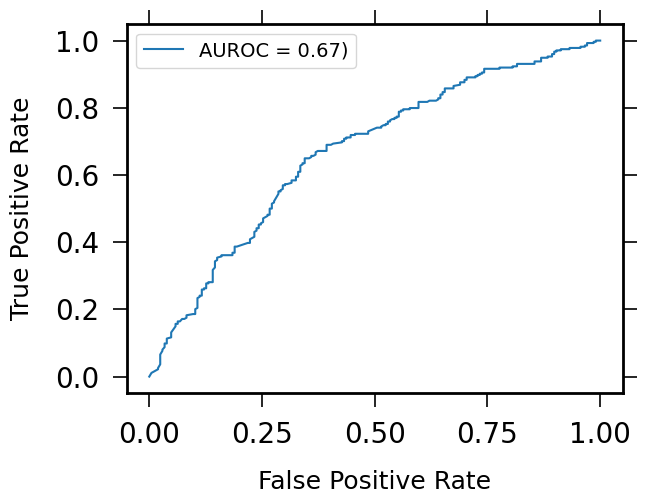

In [24]:
y_pred = subscore_initial_SOFA.predict(day1_sofa.drop(labels='discharge_disposition_binary',
                                                      axis=1))

fpr, tpr, _ = roc_curve(y_true, y_pred)
auc1 = auc(fpr, tpr)
plt.plot(fpr, tpr, label="AUROC = "+str(round(auc1, 2))+")")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

In [25]:
df = pd.DataFrame()
names = []
llf = []
llr = []
llrpval = []
aic = []
bic= []
for name, model in model_collect.items():
    # model.save(name, remove_data=True)
    names.append(name)
    llf.append(model.llf)
    llr.append(model.llr)
    llrpval.append(model.llr_pvalue)
    aic.append(model.aic)
    bic.append(model.bic)
    

df['model_name'] = names
df['LL'] = llf
df['LLR'] = llr
df['LLR_pval'] = llrpval
df['AIC'] = aic
df['BIC'] = bic
df

,model_name,LL,LLR,LLR_pval,AIC,BIC
0,overall_initial_SOFA,-320.529447,14.696581,1.262753e-04,645.058895,653.406467
1,initial_platelets,-314.696556,26.362364,2.830015e-07,633.393112,641.740684
2,subscore_initial_SOFA,-309.178782,37.397912,1.472722e-06,632.357564,661.574066


From the AIC standpoint, it seems like the best model when using Day 1 data is the one incorporating all subscores separately. But then BIC suggests it should be the initial platelets model. Nothing robustly conclusive on this front.

### Median score during visit

In [26]:
median_score_per_encounter = sofa_with_binary_outcomes.groupby(['case_number',
                                                               'discharge_disposition_binary'])['P_F_ratio_points',
                                                                                                'platelet_points',
                                                                                                'bilirubin_points',
                                                                                                'htn_points',
                                                                                                'gcs_points',
                                                                                                'renal_points',
                                                                                                'SOFA'].median().reset_index()

C:\Users\FLM9508\AppData\Local\Temp\2/ipykernel_12536/3126688022.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  median_score_per_encounter = sofa_with_binary_outcomes.groupby(['case_number',


In [27]:
print(f"There are {median_score_per_encounter['case_number'].nunique()} unique patient encounters with a valid median SOFA score")

There are 513 unique patient encounters with a valid median SOFA score


In [28]:
median_score_per_encounter = median_score_per_encounter.drop(labels='case_number',
                                                             axis=1)

In [29]:
model_collect = {}

#### Overall median SOFA

Optimization terminated successfully.
         Current function value: 0.481637
         Iterations 6


Likelihood Ratio :  204.7953303699614
LR p-value :  1.876911280377188e-46


Dep. Variable:,discharge_disposition_binary,No. Observations:,513
Model:,Logit,Df Residuals:,511
Method:,MLE,Df Model:,1
Date:,"Fri, 04 Mar 2022",Pseudo R-squ.:,0.2930
Time:,11:46:17,Log-Likelihood:,-247.08
converged:,True,LL-Null:,-349.48
Covariance Type:,nonrobust,LLR p-value:,1.877e-46


Prediction table
 [[149.  68.]
 [ 44. 252.]]
Specificity:  0.6866359447004609
Sensitivity:  0.8513513513513513


,coeff,pvals,conf_lower,conf_higher,prob,input
Intercept,3.827027,6.713463e-30,2.959167,4.694888,0.978690,Intercept
SOFA,-9.147759,1.043802e-28,-11.267422,-7.028095,0.000106,SOFA


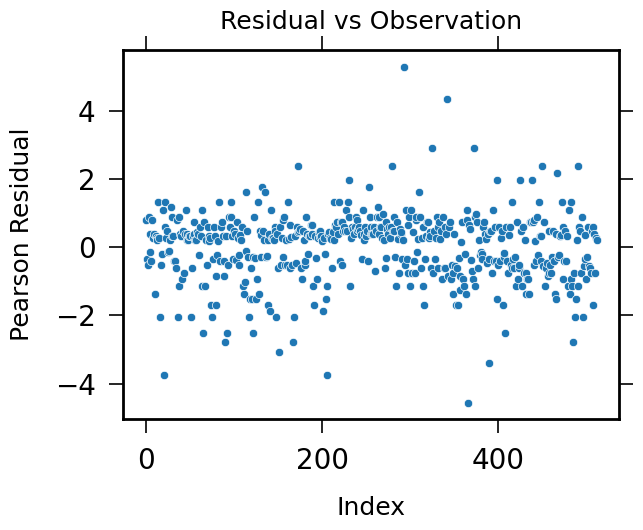

In [30]:
overall_median_SOFA = logit("discharge_disposition_binary ~ SOFA",
                            data = median_score_per_encounter).fit()

result_table = flm_tools.logistic_reg_outputter(overall_median_SOFA,
                                                title='Regression: survival ~ median SOFA')

model_collect['overall_median_SOFA'] = overall_median_SOFA

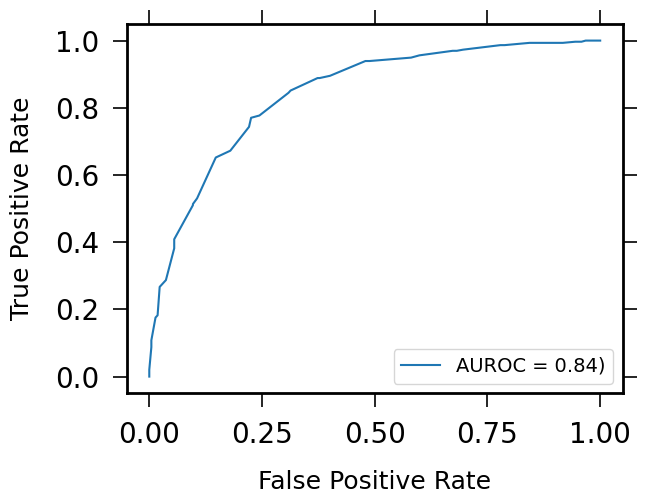

In [31]:
y_true = median_score_per_encounter['discharge_disposition_binary']
y_pred = overall_median_SOFA.predict(median_score_per_encounter['SOFA'])

fpr, tpr, _ = roc_curve(y_true, y_pred)
auc1 = auc(fpr, tpr)
plt.plot(fpr, tpr, label="AUROC = "+str(round(auc1, 2))+")")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

Wow! Or well... perhaps not so surprising given the paper showing that SOFA can predict mortality (and AUROCs were roughly similar to this one).

#### Median platelet subscore

Optimization terminated successfully.
         Current function value: 0.623374
         Iterations 5


Likelihood Ratio :  59.3726662278533
LR p-value :  1.3046874723099931e-14


Dep. Variable:,discharge_disposition_binary,No. Observations:,513
Model:,Logit,Df Residuals:,511
Method:,MLE,Df Model:,1
Date:,"Fri, 04 Mar 2022",Pseudo R-squ.:,0.08494
Time:,11:46:17,Log-Likelihood:,-319.79
converged:,True,LL-Null:,-349.48
Covariance Type:,nonrobust,LLR p-value:,1.305e-14


Prediction table
 [[ 78. 139.]
 [ 37. 259.]]
Specificity:  0.35944700460829493
Sensitivity:  0.875


,coeff,pvals,conf_lower,conf_higher,prob,input
Intercept,0.789915,3.798622e-12,0.496921,1.082908,0.687813,Intercept
platelet_points,-2.561033,1.498999e-12,-3.493495,-1.628570,0.071689,platelet_points


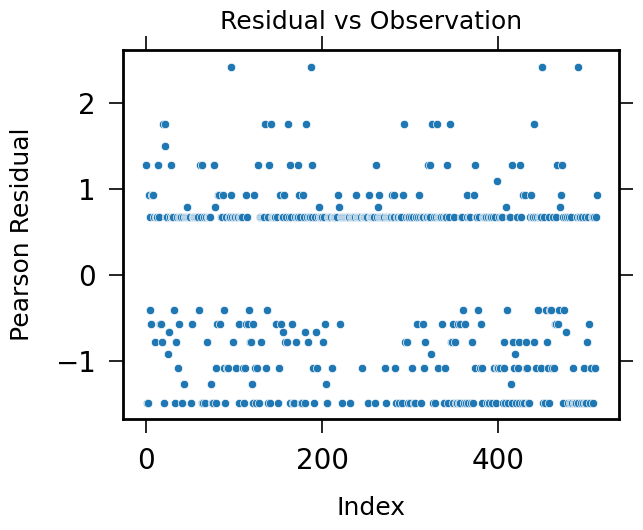

In [32]:
median_platelets = logit("discharge_disposition_binary ~ platelet_points",
                         data = median_score_per_encounter).fit()

result_table = flm_tools.logistic_reg_outputter(median_platelets,
                                                title='Regression: survival ~ median platelet points')

model_collect['median_platelets'] = median_platelets

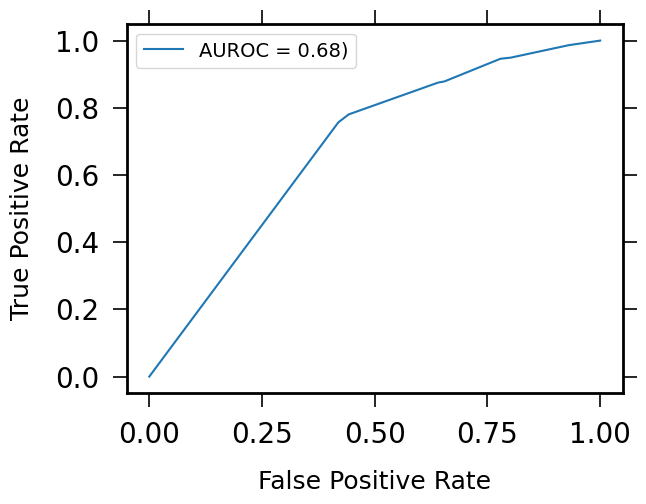

In [33]:
y_pred = median_platelets.predict(median_score_per_encounter['platelet_points'])

fpr, tpr, _ = roc_curve(y_true, y_pred)
auc1 = auc(fpr, tpr)
plt.plot(fpr, tpr, label="AUROC = "+str(round(auc1, 2))+")")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

#### All median subscores

Optimization terminated successfully.
         Current function value: 0.470587
         Iterations 6


Likelihood Ratio :  216.13240916493498
LR p-value :  6.94753242452596e-44


Dep. Variable:,discharge_disposition_binary,No. Observations:,513
Model:,Logit,Df Residuals:,506
Method:,MLE,Df Model:,6
Date:,"Fri, 04 Mar 2022",Pseudo R-squ.:,0.3092
Time:,11:46:17,Log-Likelihood:,-241.41
converged:,True,LL-Null:,-349.48
Covariance Type:,nonrobust,LLR p-value:,6.948e-44


Prediction table
 [[151.  66.]
 [ 46. 250.]]
Specificity:  0.695852534562212
Sensitivity:  0.8445945945945946


,coeff,pvals,conf_lower,conf_higher,prob,input
Intercept,4.354382,2.619252e-24,3.251833,5.456930,0.987313,Intercept
P_F_ratio_points,-0.126943,7.492344e-01,-1.149884,0.895999,0.468307,P_F_ratio_points
renal_points,-0.708825,1.245084e-02,-1.439413,0.021762,0.329858,renal_points
bilirubin_points,-0.900140,8.978265e-02,-2.266803,0.466524,0.289022,bilirubin_points
htn_points,-2.198703,2.115154e-08,-3.209622,-1.187783,0.099867,htn_points
platelet_points,-2.218841,5.185200e-07,-3.357509,-1.080172,0.098071,platelet_points
gcs_points,-3.444311,3.561308e-10,-4.858814,-2.029807,0.030939,gcs_points


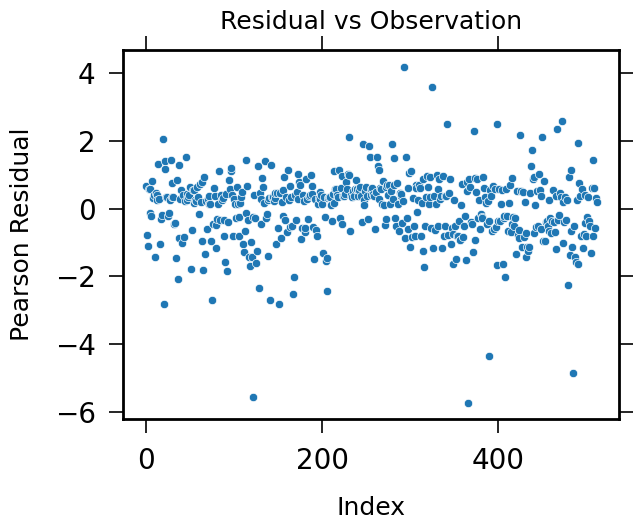

In [34]:
subscore_median_SOFA = logit("discharge_disposition_binary ~ P_F_ratio_points + platelet_points + bilirubin_points + htn_points + gcs_points + renal_points",
                             data = median_score_per_encounter).fit()

result_table = flm_tools.logistic_reg_outputter(subscore_median_SOFA,
                                                title='Regression: survival ~ median SOFA subscores')

model_collect['subscore_median_SOFA'] = subscore_median_SOFA

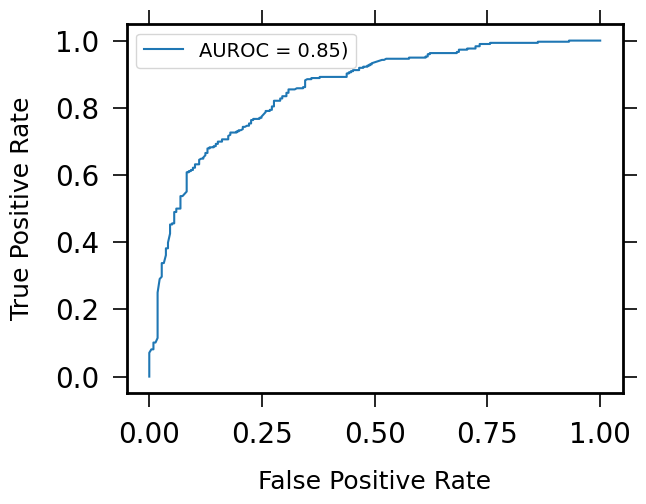

In [35]:
y_pred = subscore_median_SOFA.predict(median_score_per_encounter.drop(labels='discharge_disposition_binary',
                                                                      axis=1))

fpr, tpr, _ = roc_curve(y_true, y_pred)
auc1 = auc(fpr, tpr)
plt.plot(fpr, tpr, label="AUROC = "+str(round(auc1, 2))+")")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

In [36]:
df = pd.DataFrame()
names = []
llf = []
llr = []
llrpval = []
aic = []
bic= []
for name, model in model_collect.items():
    # model.save(name, remove_data=True)
    names.append(name)
    llf.append(model.llf)
    llr.append(model.llr)
    llrpval.append(model.llr_pvalue)
    aic.append(model.aic)
    bic.append(model.bic)
    

df['model_name'] = names
df['LL'] = llf
df['LLR'] = llr
df['LLR_pval'] = llrpval
df['AIC'] = aic
df['BIC'] = bic
df

,model_name,LL,LLR,LLR_pval,AIC,BIC
0,overall_median_SOFA,-247.079719,204.795330,1.876911e-46,498.159438,506.639990
1,median_platelets,-319.791051,59.372666,1.304687e-14,643.582103,652.062654
2,subscore_median_SOFA,-241.411180,216.132409,6.947532e-44,496.822360,526.504291


Some thoughts:  
1. It's not clear whether PF_ratio is informative. An initial hypothesis was that since pneumonia is a respiratory disease, its most informative feature would be a respiratory organ failure score. That wasn't the case, but we have to keep in mind that PF_ratios are not measured if a patient isn't on a ventilator. A lot of imputation was done for that variable. And in the end, it might just be that the most informative subscores are those that are frequently assessed!
2. However, it is striking that platelets consistently appeared on both the initial and the median SOFA scores assessments (that's why I'm showing platelets individually). Considering this is a measurement that should be taken every day, it can either mean that its consistent measurement contributes to its informative value to the models (although not exclusive to platelets in this model), or that indeed it is a very telling measurement (think about analysis on masterthesis01, where abnormalities in coagulation were a tell-tale sign of bad outcomes). Curiously, it was also an "important" feature when running GradientBoosting.